In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk

from collections import Counter
from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [2]:
dv = pd.read_csv("../rawdata/hololivecomments_cleaned.csv")

In [3]:
dv["created_utc"] =  pd.to_datetime(dv["created_utc"]).dt.tz_convert(None)

In [4]:
# Check dataframe

display(dv["submission_id"].count())
display(dv.info())
display(dv.head(1))

2285265

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2285265 entries, 0 to 2285264
Data columns (total 9 columns):
 #   Column         Dtype         
---  ------         -----         
 0   subreddit      object        
 1   id             object        
 2   submission_id  object        
 3   created_utc    datetime64[ns]
 4   author         object        
 5   score          float64       
 6   body           object        
 7   parent_id      object        
 8   permalink      object        
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 156.9+ MB


None

,subreddit,id,submission_id,created_utc,author,score,body,parent_id,permalink
0,Hololive,ff4gful,erj4fp,2020-01-20 23:30:06,raystrife96,4.0,uptodate rushia year outfit permanent pretty s...,t3_erj4fp,/r/Hololive/comments/erj4fp/i_have_some_questi...


In [29]:
# Function and Procedure

tokenSpace = tokenize.WhitespaceTokenizer()

def counter(text, columnText, quantity): # counter(dv[dv["score"] == 1], "body", 10)
    allWords = ' '.join([text for text in text[columnText].astype('str')])
    tokenPhrase = tokenSpace.tokenize(allWords)
    frequency = nltk.FreqDist(tokenPhrase) 
    dfFrequency = pd.DataFrame({columnText: list(frequency.keys()), "Frequency": list(frequency.values())}) 
    
    dfFrequency = dfFrequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = dfFrequency, x = columnText, y = "Frequency", palette="deep")
    ax.set(ylabel = "Count")
    ax.set_title('Top {} in {} Where (Certain Condition)'.format(quantity, columnText))
    plt.xticks(rotation='horizontal')
    plt.show()
    
def wordappear_permonth(word):
    # Make a data copy, so the origin of data won't changed
    dv1 = dv.copy()
    
    # convert the body column to strings to ensure that the regular expression search works correctly
    dv1['body'] = dv1['body'].astype(str)

    # create a new column that contains a boolean indicating whether the word appears in the body attribute
    dv1['contains_word'] = dv1['body'].apply(lambda x: True if re.search(r'\b{}\b'.format(word), x, re.IGNORECASE) else False)

    # group the DataFrame by the year and month of the created_utc attribute, and count the number of rows in each group where the word appears in the body
    word_counts = dv1[dv1['contains_word'] == True].groupby(dv1['created_utc'].dt.to_period('M')).size()

    # convert the Period objects to timestamps
    word_counts.index = word_counts.index.to_timestamp()

    # create the bar plot
    fig, ax = plt.subplots(figsize=(12,6))
    ax.bar(word_counts.index, word_counts, width=20)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Appearances of "{}"'.format(word))
    ax.set_title('Number of "{}" Appearances by Month'.format(word))

    # rotate x-axis labels
    plt.xticks(rotation=90, ha='right')

    plt.show()
    
def numberofcomments_permonth():
    # Make a data copy, so the origin of data won't changed
    dv1 = dv.copy()

    # Set created_utc column as the index
    dv1.set_index('created_utc', inplace=True)

    # Group the rows by month and count the number of rows per month
    monthly_counts = dv1.resample('M').size()

    # Plot the graph
    plt.subplots(figsize=(12,6))
    plt.plot(monthly_counts.index, monthly_counts.values)
    plt.title('Number of Rows per Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Rows')

    # rotate x-axis labels
    plt.xticks(rotation=90, ha='right')

    plt.show()
    
def top_authormention(word, quantity):
    # Make a data copy, so the origin of data won't changed
    dv1 = dv.copy()
    
    # Convert the body column to strings to ensure that the regular expression search works correctly
    dv1['body'] = dv1['body'].astype(str)

    # Create a new column that contains a boolean indicating whether the word appears in the body attribute
    dv1['contains_word'] = dv1['body'].apply(lambda x: True if re.search(r'\b{}\b'.format(word), x, re.IGNORECASE) else False)

    # Group the DataFrame by author and count the number of rows in each group where the word appears in the body
    word_counts = dv1[dv1['contains_word'] == True].groupby('author').size().sort_values(ascending=False)[:quantity]

    # Create the bar plot
    fig, ax = plt.subplots()
    ax.bar(word_counts.index, word_counts)
    ax.set_xlabel('Author')
    ax.set_ylabel('Number of Appearances of "{}"'.format(word))
    ax.set_title('Top {} Authors Mentioning "{}"'.format(quantity, word))

    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')

    plt.show()
    
def top_authormentionlistofwords(those_words, quantity): # those_words need to be a list of str
    # Make a data copy, so the origin of data won't changed
    dv1 = dv.copy()
    
    # convert the body column to strings to ensure that the regular expression search works correctly
    dv1['body'] = dv1['body'].astype(str)

    # create a new column that contains a boolean indicating whether any of the those words appears in the body attribute
    dv1['contains_those_words'] = dv1['body'].apply(lambda x: True if any(re.search(r'\b{}\b'.format(word), x, re.IGNORECASE) for word in those_words) else False)

    # group the DataFrame by author, and count the number of rows in each group where a those word appears in the body
    those_words_counts = dv1[dv1['contains_those_words'] == True].groupby('author').size().sort_values(ascending=False)[:10]

    # create the bar plot
    fig, ax = plt.subplots()
    ax.bar(those_words_counts.index, those_words_counts)
    ax.set_xlabel('Author')
    ax.set_ylabel('Number of Appearances of Words Similat to "{}"'.format(those_words[0]))
    ax.set_title('Top {} Authors by Number of Appearances of Words Similar to "{}"'.format(quantity, those_words[0]))
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
def topx_score(quantity):
    # Make a data copy, so the origin of data won't changed
    dv1 = dv.copy()
    
    # Sort the dataframe based on the 'score' column in descending order
    sorted_dv1 = dv1.sort_values(by=['score'], ascending=False)

    # Show the top x rows with the highest score
    top_x = sorted_dv1.head(quantity)
    print(top_x)
    
def topx_scoreauthor(quantity):
    # Make a data copy, so the origin of data won't changed
    dv1 = dv.copy()
    
    # Group the dataset by author and sum the scores
    grouped = dv1.groupby('author')['score'].sum().reset_index()

    # Sort the authors by their total score and take the top x
    top_authors = grouped.sort_values('score', ascending=False).head(quantity)

    # Plot the graph
    plt.subplots(figsize=(12,6))
    plt.bar(top_authors['author'], top_authors['score'])
    plt.xlabel('Author')
    plt.ylabel('Combined Score')
    plt.title('Top {} Authors by Combined Score'.format(quantity))
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
def authorscore(author):
    # Make a data copy, so the origin of data won't changed
    dv1 = dv.copy()
    
    # Filter the rows by the author name
    author_rows = dv1[dv1['author'] == author]

    # Calculate the combined score
    combined_score = author_rows['score'].sum()

    # Print the result
    print(f"The combined score of {author} is {combined_score}.")

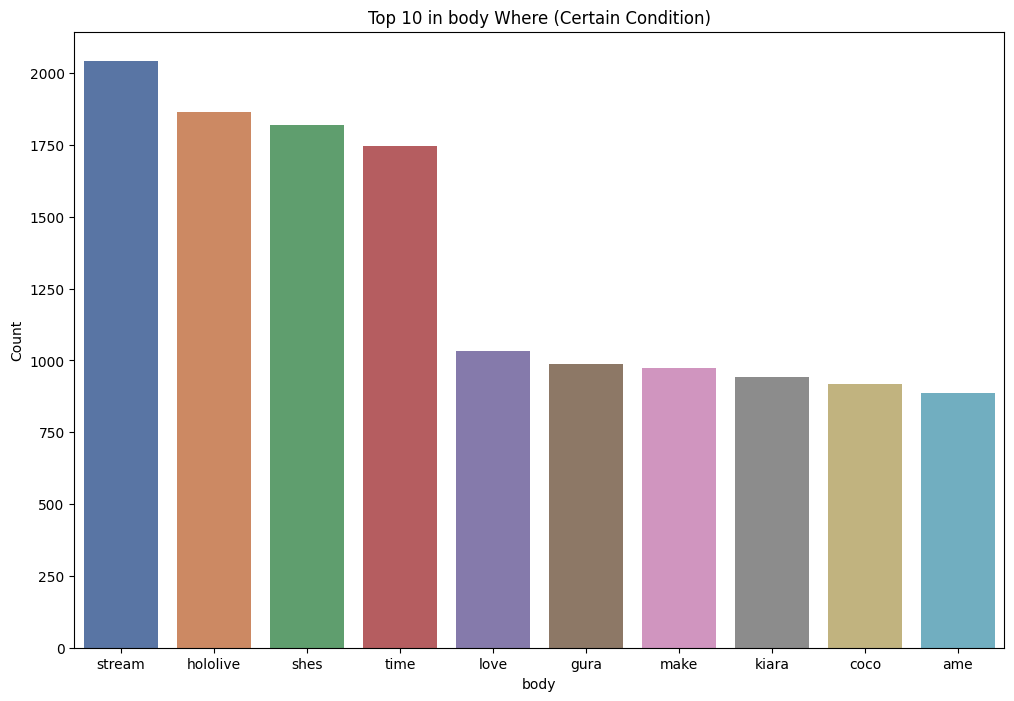

In [6]:
# Plot grafik yang menunjukkan 10 kata yang paling sering
# muncul untuk komentar yang skornya lebih dari 250

counter(dv[dv["score"] >= 250], "body", 10)

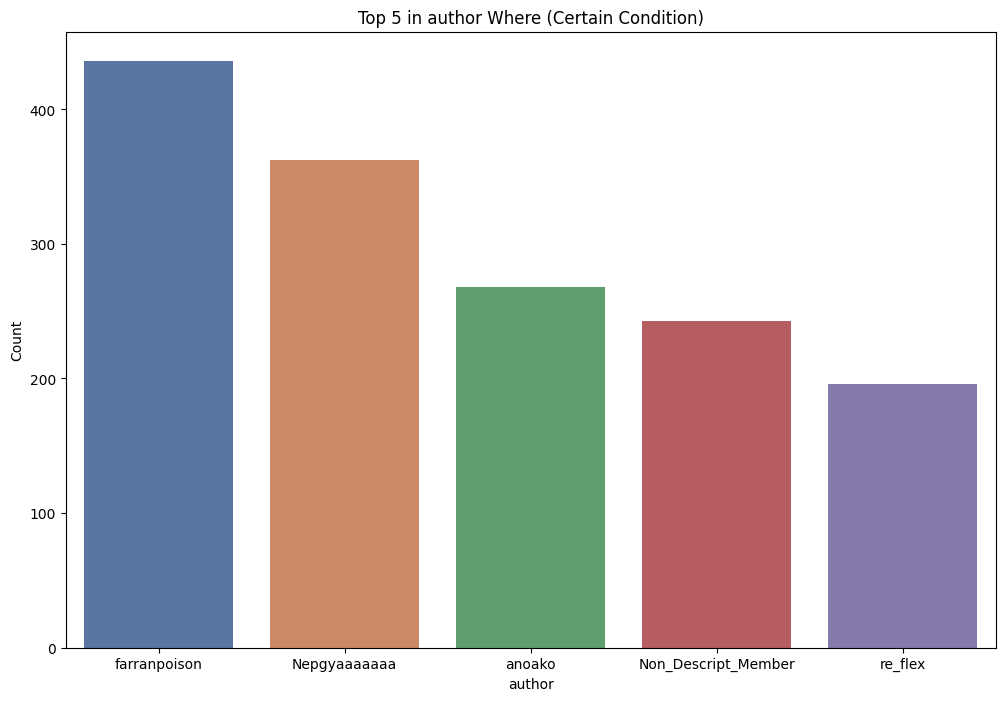

In [7]:
# Plot grafik yang menunjukkan 5 user/author yang paling sering
# berkomentar untuk komentar yang skornya lebih dari 250

counter(dv[dv["score"] >= 250], "author", 5)

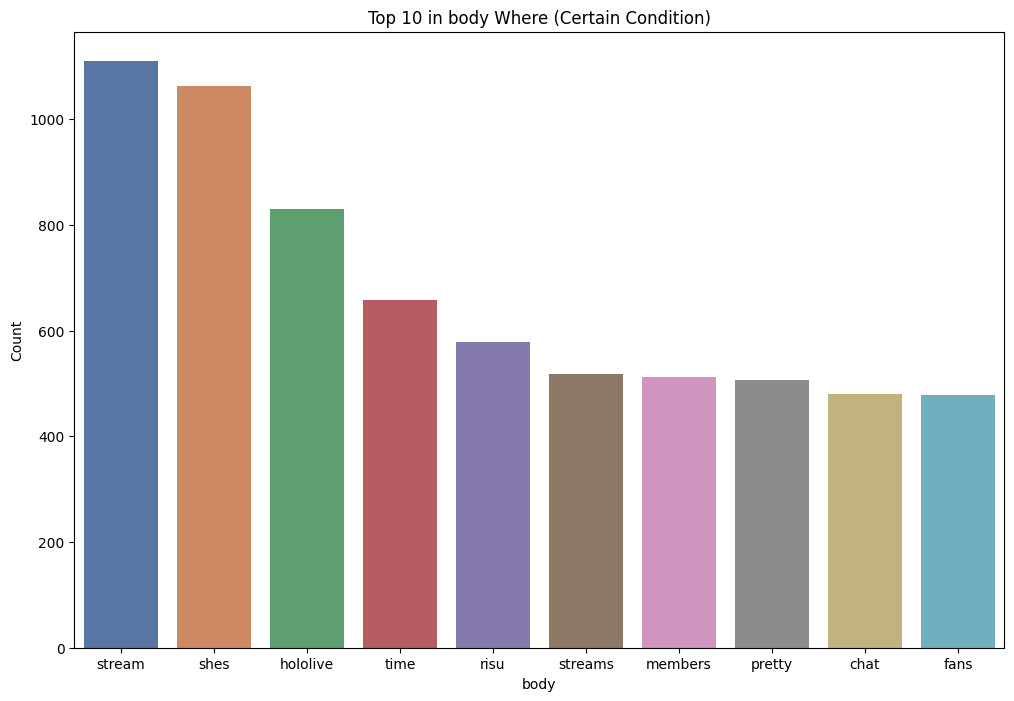

In [8]:
# Menunjukkan 10 kata yang paling sering digunakan oleh "farranpoison"
# atau user paling banyak komentar

counter(dv[dv["author"] == "farranpoison"], "body", 10)

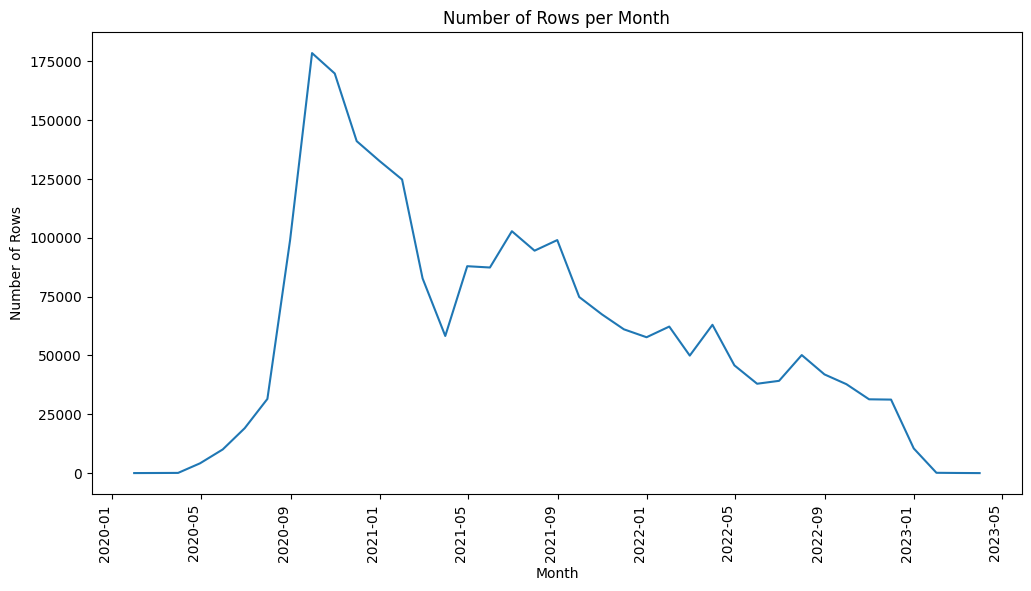

In [9]:
numberofcomments_permonth()

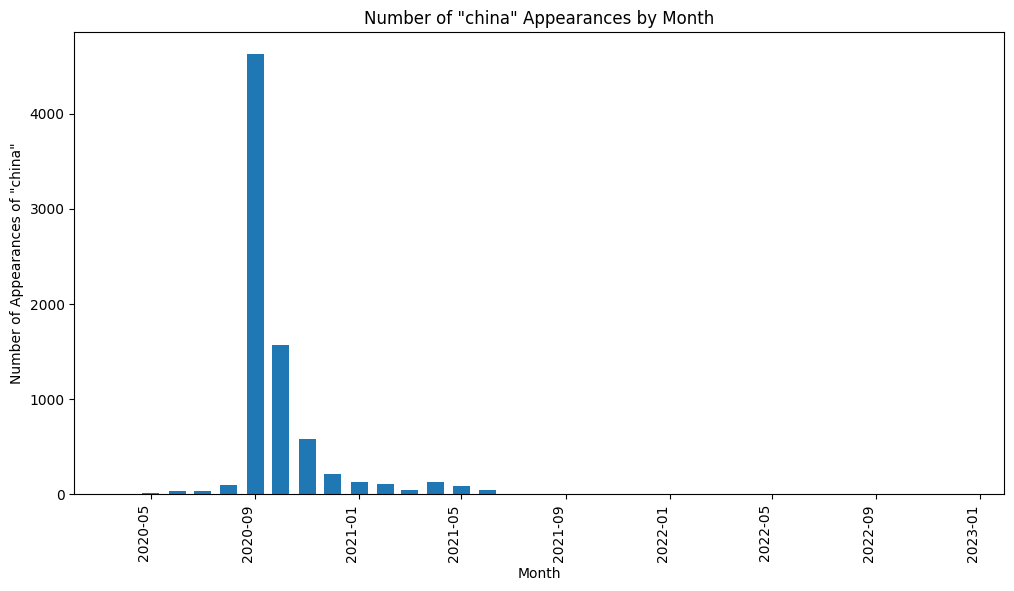

In [10]:
wordappear_permonth("china") # liat desain di Kibana, buat desain interface yang kemungkinan dimengerti orang
# assuming kita sebagai user karena kalau desain itu bergantung kebutuhan user

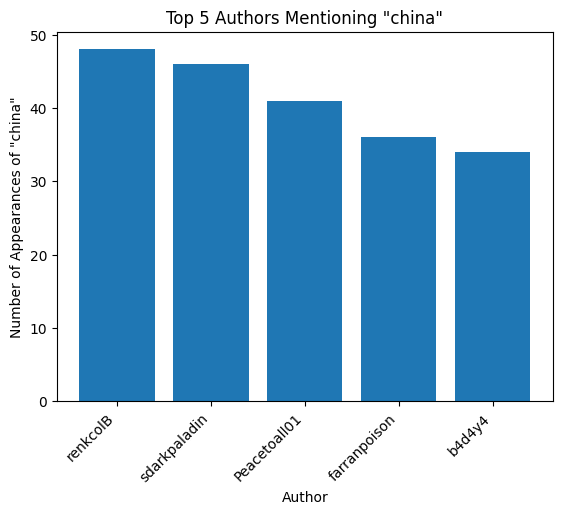

In [11]:
top_authormention("china", 5)

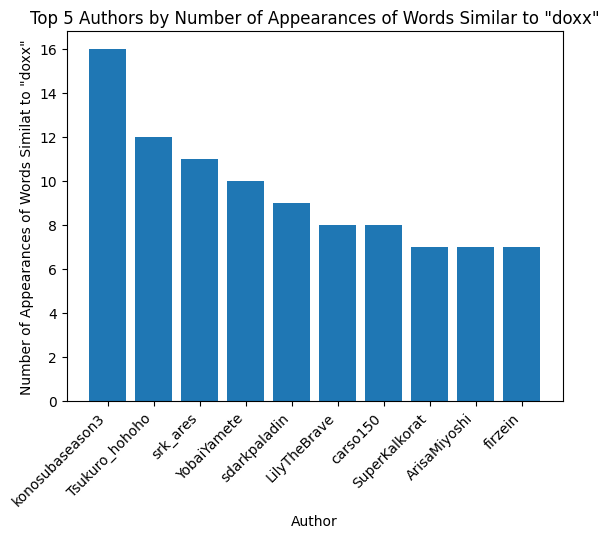

In [12]:
# define the list of those words you want to search for in the body attribute
those_words = ['doxx', 'harass', 'threat']

top_authormentionlistofwords(those_words, 5)


In [17]:
topx_score(10)

        subreddit       id submission_id         created_utc  \
1627130  Hololive  hghc3jg        q7b680 2021-10-13 13:35:54   
957019   Hololive  gnv55ll        lm8y7h 2021-02-18 07:55:30   
426961   Hololive  g99ilkz        jdnv29 2020-10-18 21:50:34   
1254519  Hololive  h13zcoe        nvlymp 2021-06-09 03:19:09   
1731455  Hololive  hn32pbv        r833wy 2021-12-03 16:42:27   
1772253  Hololive  hpxxaqb        rod22i 2021-12-25 19:03:34   
1547867  Hololive  hca4ofg        plf8ks 2021-09-10 06:08:10   
1885629  Hololive  hy7izuw        t00yri 2022-02-24 06:30:54   
857627   Hololive  gjokcd4        kzlo72 2021-01-18 03:05:17   
1885611  Hololive  hy7ijpi        t00yri 2022-02-24 06:26:28   

                      author    score  \
1627130         momosuzunene  10199.0   
957019    HoushouMarineLEGIT   7874.0   
426961   SakuraMiko_hololive   7417.0   
1254519    HandfulOfMassiveD   6985.0   
1731455         momosuzunene   6012.0   
1772253             hololive   5941.0   
1547867 

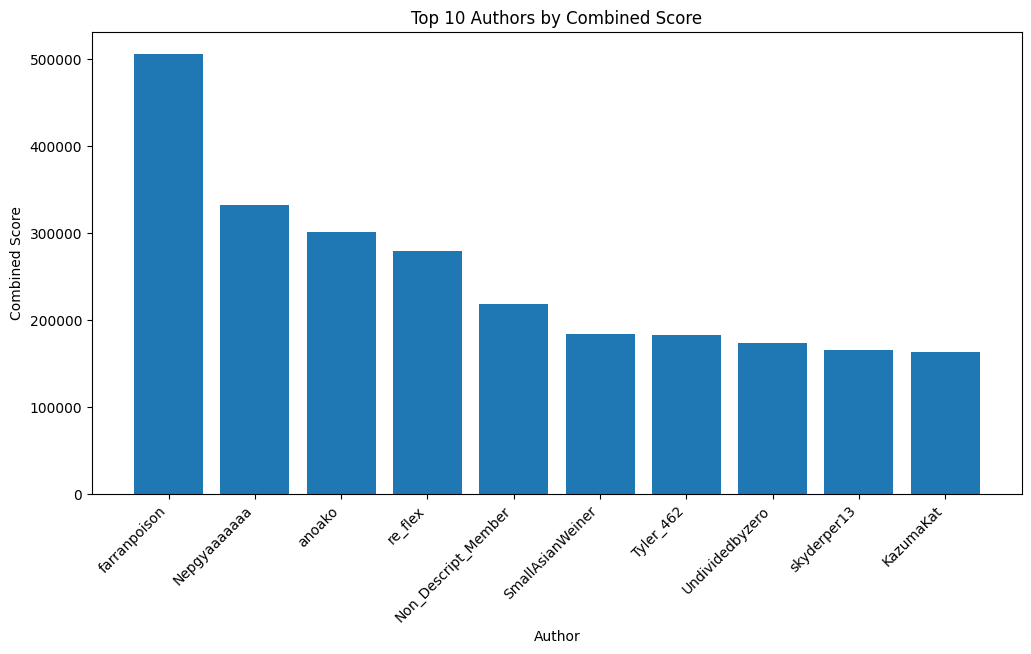

In [21]:
topx_scoreauthor(10)

In [28]:
authorscore("momosuzunene")

The combined score of momosuzunene is 26475.0.
